In [1]:
import re
from underthesea import word_tokenize
from rank_bm25 import BM25Okapi, BM25Plus
import pickle
from transformers import RobertaTokenizerFast, RobertaForQuestionAnswering, DefaultDataCollator, TrainingArguments, Trainer, AutoModelForQuestionAnswering
from datasets import Dataset
import json
import torch


C:\Users\ADMIN\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file = open('data.txt',encoding='utf-8').read().split("\n")
data = []
for line in file:
    if re.search("^.*\.", line) or re.search("^.*\)", line):
        data.append(line.lower())
stopwords = open('../stopwords.txt', encoding='utf-8').read().split(" ")

In [3]:
def removeStopwords(sentence):
  words = word_tokenize(sentence)
  word = [w.lower() for w in words if w not in (stopwords)]
  sentence_clean = " ".join(word)
  
  return sentence_clean

In [4]:
def bm25okapi_search(tokenized_query, bm25, corpus, n_results = 1):
    top_results = bm25.get_top_n(tokenized_query, corpus, n = n_results)
    top_results_return = [' '.join(top_result.split(' ')) 
                             for top_result in top_results]
    
    return top_results_return

In [5]:
#to read bm25 object
with open('bm25result', 'rb') as bm25result_file:
    bm25result = pickle.load(bm25result_file)

In [6]:
model = RobertaForQuestionAnswering.from_pretrained("phobert_law")
tokenizer = RobertaTokenizerFast.from_pretrained("phobert_law")


In [7]:
while(True):
    inputQuestion = input("Input context: \n")
    if (inputQuestion.lower() == "ok"):
        break
    tokenized_query = word_tokenize(removeStopwords(inputQuestion))
    topContext = bm25okapi_search(tokenized_query = tokenized_query,
                 bm25 = bm25result, 
                 corpus = data,
                 n_results = 5)
    choosenContext = topContext[0]
    inputs = tokenizer(inputQuestion.lower(), choosenContext, return_tensors="pt",max_length=128, padding="max_length", truncation="only_second")
    with torch.no_grad():
        outputs = model(**inputs)
    answer_start_index = outputs.start_logits.argmax()
    answer_end_index = outputs.end_logits.argmax()
    predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
    print("Context: " + choosenContext + "\n")
    print("Question " + inputQuestion+ "\n")
    if(tokenizer.decode(predict_answer_tokens) == ""):
        print("Answer: Chưa thể tìm thấy câu trả lời \n")
    else:
        print("Answer: " + tokenizer.decode(predict_answer_tokens)+ "\n")


In [8]:
# Function read file test
def read_data_test(filePath):
    f = open(filePath,encoding='utf-8')
    fileRead = json.load(f)
    question = []
    answer = []
    for object in fileRead:
        question.append(object["question"].lower())
        answer.append(object["answer"].lower())
    dataset = {
    "question": question,
    "answer": answer
    }
    return dataset

# function to get answer
def getAnswer(inputQuestion):
    tokenized_query = word_tokenize(removeStopwords(inputQuestion))
    topContext = bm25okapi_search(tokenized_query = tokenized_query,
                 bm25 = bm25result, 
                 corpus = data,
                 n_results = 5)
    choosenContext = topContext[0]
    inputs = tokenizer(inputQuestion.lower(), choosenContext, return_tensors="pt",max_length=128, padding="max_length", truncation="only_second")
    with torch.no_grad():
        outputs = model(**inputs)
        answer_start_index = outputs.start_logits.argmax()
        answer_end_index = outputs.end_logits.argmax()
        predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
        if(tokenizer.decode(predict_answer_tokens) == ""):
            return ""
        else:
            return tokenizer.decode(predict_answer_tokens)

In [9]:
# To get score predict with bleu
test_data = read_data_test("./QA_data/qa_test.json")
test_data = Dataset.from_dict(test_data)


In [10]:
predicts = []
for q in test_data["question"]:
    predicts.append(getAnswer(q))

In [12]:
from nltk.translate.bleu_score import sentence_bleu
#function to get score of results
def getScore(ref, candi):
    score = sentence_bleu(ref, candi)
    return float('{:.4f}'.format(score))

In [14]:
reference= []
for i in test_data["answer"]:
    reference.append(i.split())


In [15]:
scores = []
for i in predicts:
    scores.append(getScore(reference,i.split()))

C:\Users\ADMIN\AppData\Roaming\Python\Python37\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\ADMIN\AppData\Roaming\Python\Python37\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


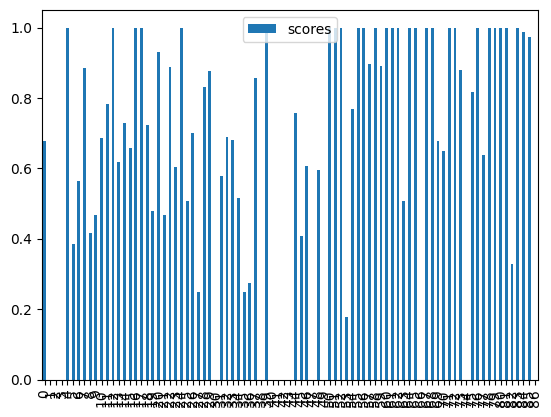

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
df1 = {
    "scores": scores
}
df = pd.DataFrame(df1)
lines = df.plot.bar()

In [16]:
average = sum(scores)/len(scores)
average

0.6495758620689653

In [13]:
import datasets
rouge = datasets.load_metric("rouge")
rouge_output = rouge.compute(predictions=predicts, references=test_data["answer"], rouge_types=["rouge2"])["rouge2"].mid

print(rouge_output)


C:\Users\ADMIN\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


Score(precision=0.5708938341715442, recall=0.7178232812959959, fmeasure=0.5982042626221233)
